In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Tickers and date range for data accessing

In [62]:
tickers = ["WBD","BCC","SOLV","PFE","OXY","PG","T","TJX","MMM","BA","O","KMI","CSCO","CVS","DIS","MA","RTX","AXP","BX"]

years_delta = 1
end_date = datetime.today()
start_date = end_date - timedelta(days =  years_delta * 365)

## Downloding the adjusted close price
> This is done as the `adj Close` is relatively more accurate when it comes to close prices as it includes dividends and stock splits.
> An optimal portfolio would underweigh a portfolio that pays more dividends as it wouldn't be refleced if you use `close price`

In [63]:
adj_close_df = pd.DataFrame()

for scrip in tickers:
    data = yf.download(scrip, start = start_date, end = end_date)
    adj_close_df[scrip] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [64]:
adj_close_df

,WBD,BCC,SOLV,PFE,OXY,PG,T,TJX,MMM,BA,O,KMI,CSCO,CVS,DIS,MA,RTX,AXP,BX
Date,,,,,,,,,,,,,,,,,,,
2023-11-13,9.8900,96.008781,NaN,27.310575,60.709110,148.756653,14.671463,90.175194,74.135399,204.539993,47.391212,15.605092,50.970062,65.077736,88.740051,392.603333,79.985390,152.912354,95.290253
2023-11-14,10.4400,103.700829,NaN,27.574446,60.827354,148.424896,14.718548,91.520790,75.959000,207.470001,49.518593,15.869583,51.887386,65.749619,90.357292,395.888672,78.678795,155.458572,100.028923
2023-11-15,10.5600,103.069733,NaN,28.450874,60.403641,147.741898,14.840967,88.483299,77.438660,208.710007,49.832008,15.982938,51.994732,66.354332,93.194916,395.072327,78.620277,157.955246,101.676735
2023-11-16,10.3200,101.258759,NaN,28.055069,59.428120,149.117661,14.953969,87.434517,77.755501,206.600006,50.420834,15.888477,46.881138,65.509659,93.770378,395.341125,78.806915,157.578781,101.111214
2023-11-17,10.7100,102.950829,NaN,28.196426,60.068611,147.400406,14.972803,87.899536,77.454910,208.039993,50.249882,16.020721,46.607887,66.047173,93.413193,398.526947,78.266670,161.056305,102.339752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-06,8.3800,141.759995,74.139999,26.941530,51.389999,161.050003,22.320000,115.629997,133.919998,147.160004,57.000000,26.350000,57.869999,61.610001,98.889999,521.130005,121.589996,295.160004,176.380005
2024-11-07,9.3700,140.850006,75.070000,27.039999,51.209999,163.410004,22.040001,116.849998,133.070007,150.979996,56.380001,26.410000,58.080002,57.070000,98.930000,517.880005,120.080002,286.820007,176.300003
2024-11-08,9.1800,142.320007,72.430000,26.719999,50.529999,167.710007,22.340000,117.830002,134.339996,151.679993,57.509998,26.879999,58.060001,55.540001,99.019997,524.760010,123.550003,287.600006,177.460007


## Calculate the Lognormal returns for each scrip
> The `shift` operator help you take in the value after shifting the index from 1 row down. That is, the first index would be
> from the date 15-10-2019 after shifting instead of 14-10-2019

In [65]:
lognormal_rets = np.log(adj_close_df/adj_close_df.shift(1) ) 

In [66]:

#drop the missing values 
lognormal_rets = lognormal_rets.dropna()

In [67]:
lognormal_rets

,WBD,BCC,SOLV,PFE,OXY,PG,T,TJX,MMM,BA,O,KMI,CSCO,CVS,DIS,MA,RTX,AXP,BX
Date,,,,,,,,,,,,,,,,,,,
2024-04-02,-0.035904,-0.026500,-0.032356,-0.006152,0.013170,-0.000062,0.001142,-0.002309,-0.012630,-0.007734,-0.011098,0.000543,-0.013682,-0.074882,0.010559,0.002151,0.008049,-0.009180,-0.036687
2024-04-03,0.029055,0.013073,-0.046036,-0.012051,0.006668,-0.027913,0.005124,-0.022263,0.003763,-0.016731,-0.001893,0.007033,-0.004504,0.010511,-0.031764,-0.004201,-0.010199,0.004866,0.002056
2024-04-04,-0.033783,-0.011731,0.047530,-0.021163,-0.001182,-0.004493,-0.002274,-0.015853,-0.028849,-0.008854,-0.002846,-0.006490,-0.013010,-0.009428,-0.016013,-0.016153,0.017881,-0.028463,-0.004434
2024-04-05,-0.014320,0.018862,0.044659,0.000375,0.023672,0.004173,-0.008574,0.011010,0.005397,-0.000819,0.007384,0.001626,0.009104,0.009160,0.010957,0.015588,0.023683,0.012985,0.012382
2024-04-08,0.023754,0.002891,-0.044510,-0.003005,-0.007537,-0.000384,-0.009807,-0.006009,0.009838,-0.008665,0.011815,-0.005432,-0.006406,-0.001879,-0.008739,0.004941,0.001867,0.007390,0.013546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-05,0.004884,0.031020,0.013624,0.008251,-0.003170,0.004111,0.005913,0.009362,0.005310,-0.026597,-0.007959,0.008943,0.005893,0.012547,0.008731,-0.000040,0.008271,0.021058,0.015327
2024-11-06,0.020495,0.023337,0.013306,-0.022765,0.019452,-0.028826,0.012171,0.016392,0.056842,-0.025759,-0.031431,0.064260,0.029994,0.107328,0.023119,0.030333,0.021699,0.067334,0.039080
2024-11-07,0.111665,-0.006440,0.012466,0.003648,-0.003509,0.014548,-0.012624,0.010496,-0.006367,0.025627,-0.010937,0.002274,0.003622,-0.076546,0.000404,-0.006256,-0.012496,-0.028663,-0.000454


## Covarience matrix
> The cov matrix helps you measure the total risk of the portfolio. Each asset has a certain correlation and covarience with
> each other. So, we can std dev in the most optimal way possible using this.


In [68]:
# multiply by 252 to convert the result from daily to annualized 
cov_matrix = lognormal_rets.cov() * 252 
cov_matrix

,WBD,BCC,SOLV,PFE,OXY,PG,T,TJX,MMM,BA,O,KMI,CSCO,CVS,DIS,MA,RTX,AXP,BX
WBD,0.240019,0.069997,0.023225,0.033169,0.006934,-0.001622,0.005688,0.015911,0.028318,0.045593,0.011796,0.023343,0.029531,0.013602,0.031494,0.007577,0.001035,0.026917,0.046337
BCC,0.069997,0.158247,0.024421,0.020490,0.020004,-0.010342,0.000496,0.021368,0.037237,0.032635,0.012442,0.021105,0.021975,0.038963,0.033083,0.014536,0.019805,0.034738,0.065238
SOLV,0.023225,0.024421,0.111078,0.011710,0.009240,-0.000984,0.009840,0.006209,0.007774,0.019382,0.003138,0.007197,0.016861,0.017418,0.013316,0.008162,0.008780,0.013924,0.020202
PFE,0.033169,0.020490,0.011710,0.051645,-0.002741,0.005790,0.013705,0.009410,0.023056,0.019286,0.013495,0.003713,0.011515,-0.002730,0.009711,-0.000226,0.004462,0.006992,0.013266
OXY,0.006934,0.020004,0.009240,-0.002741,0.049455,-0.007200,0.001081,-0.000529,0.002086,0.015291,-0.002707,0.020971,0.011004,0.018486,0.008827,0.008242,0.008063,0.019571,0.016913
PG,-0.001622,-0.010342,-0.000984,0.005790,-0.007200,0.025297,0.008391,0.003306,0.005153,-0.003747,0.011128,-0.001180,0.000161,-0.002417,-0.000634,0.002674,-0.000830,-0.008079,-0.002457
T,0.005688,0.000496,0.009840,0.013705,0.001081,0.008391,0.038391,0.002037,-0.000635,-0.007537,0.010145,0.004964,0.005138,0.015755,0.005005,0.002614,0.005175,0.002335,-0.001536
TJX,0.015911,0.021368,0.006209,0.009410,-0.000529,0.003306,0.002037,0.031975,0.009173,0.011185,0.003928,0.005283,0.011754,0.010747,0.014769,0.008394,0.003917,0.009369,0.016610
MMM,0.028318,0.037237,0.007774,0.023056,0.002086,0.005153,-0.000635,0.009173,0.110152,0.015838,0.005820,0.014612,0.013542,0.035614,0.016446,0.013056,0.006662,0.021525,0.021816
BA,0.045593,0.032635,0.019382,0.019286,0.015291,-0.003747,-0.007537,0.011185,0.015838,0.114153,0.006640,0.008840,0.018265,-0.003493,0.015998,0.009144,0.016061,0.023099,0.027023


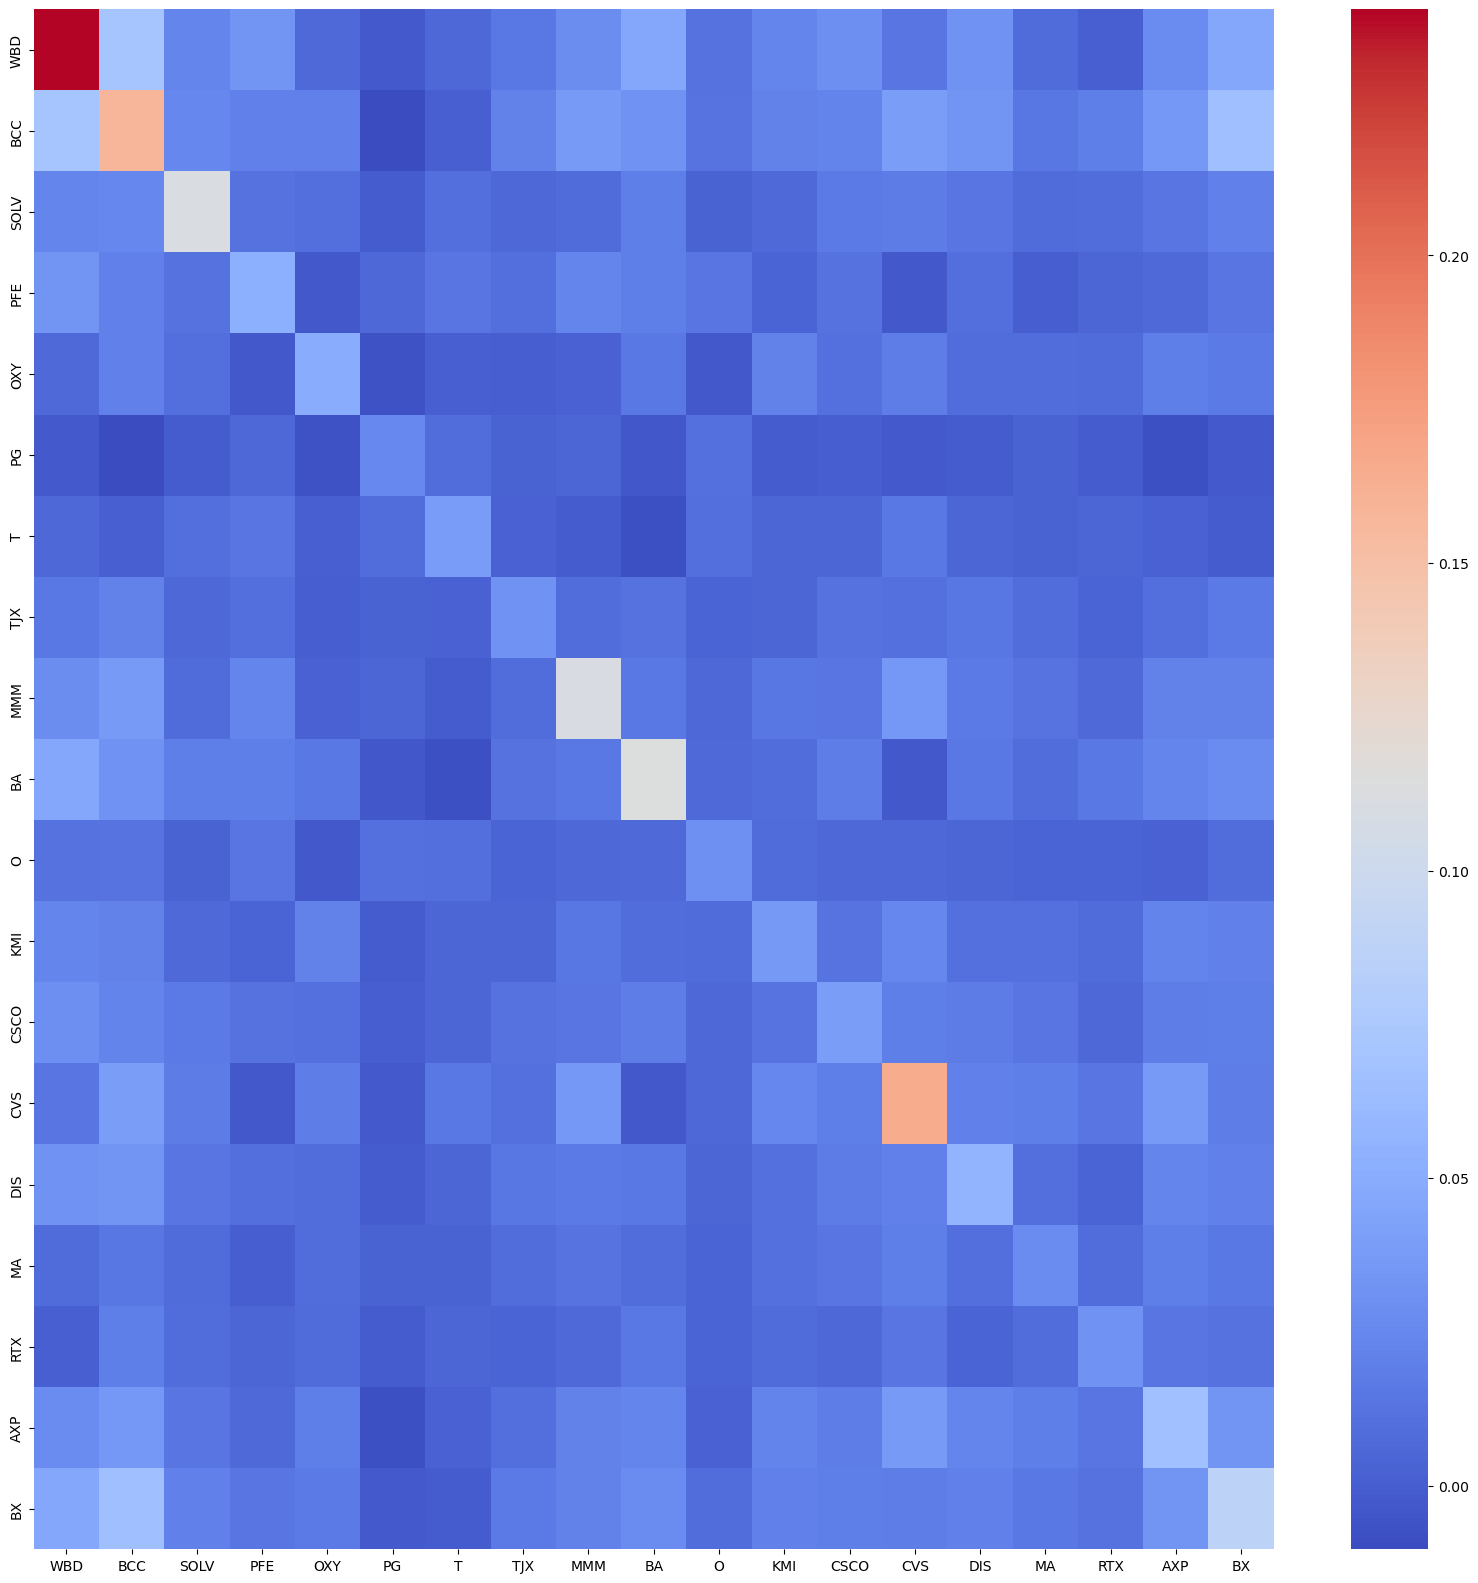

In [69]:
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(cov_matrix, cmap='coolwarm')
plt.show()

## Portfolio Performance 
> Standard deviation

> Expected returns

> Sharpe ratio

In [70]:
def variance(weights, cov):
    return weights.T @ cov @ weights

def std_dev(weights, cov):
    return np.sqrt(variance(weights,cov))

## Expected returns from historical values 
> this should be optimized 

In [71]:

def exp_returns(weights, log_returns):
    # Check if the weights sum to 1, normalize if necessary
    if np.sum(weights) != 1:
        weights = weights / np.sum(weights)

    # Calculate the mean of the log returns
    mean_log_returns = log_returns.mean()

    # Compute expected returns using matrix multiplication
    expected_return = np.dot(weights, mean_log_returns) * 252  # Annualize the returns (assuming 252 trading days)

    return expected_return

## Sharpe Ratio 
> SR = ( portfolio returns - risk free rate ) / std dev

In [72]:
# risk free rate is usually around 3 % 

def sharpe_ratio(weights, log_returns, cov, risk_free_rate):
    return ( exp_returns(weights, log_returns) - risk_free_rate ) / std_dev( weights, cov )

In [73]:
# negative sharpe ratio
# this functoins is to minimize the value

def neg_sharpe_ratio(weights, log_returns, cov, risk_free_rate):
    return -1 * ( exp_returns(weights, log_returns) - risk_free_rate ) / std_dev( weights, cov )

## Constraints and bounds
conditions that must be met by the solution during optimization. 
> Sum of all portfolio weights must equal to 1.

> type is set to `equqlity` => equality,

> Fun is set to `checksum' => ensures if the portfolio weights sum upto 1

> Bounds are the limits on variables during optimization. Here, the variables are portfolio weights, and each should be
> between 0 and 1

In [80]:
constraints = { 'type' : 'eq', 'fun' : lambda weights: np.sum( weights ) - 1 }
# The max size of a position could only be 40% and the min could only be 0%
# no negatives as we are not going short on assets. We are only on the buy side
bounds = [ (0, 0.3) for each in range( len( tickers ) ) ] 

In [81]:
# setting initial weights
init_weights = np.array( [ 1 / len(tickers) ] * len(tickers) )
init_weights

array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158])

## Optimization
> SLSQP, AKA sequential least square quadratic programming, which is a numerical optimization technique suitable for solving nonlinear optimization problems with constraints

In [82]:
risk_free_rate = 0.0409

optimized_res = minimize(
    neg_sharpe_ratio, init_weights, args = ( lognormal_rets, cov_matrix, risk_free_rate), 
    method = 'SLSQP',
    constraints = constraints,
    bounds = bounds
)

In [83]:
# accesses the optimal weights from res
optimal_weights = optimized_res.x 
optimal_weights

array([7.36465690e-14, 1.50118442e-13, 0.00000000e+00, 1.36190032e-14,
       7.92134413e-14, 0.00000000e+00, 2.72067842e-01, 1.06344663e-01,
       7.88540612e-02, 4.51897429e-14, 0.00000000e+00, 3.00000000e-01,
       0.00000000e+00, 2.36586554e-13, 5.86265753e-14, 0.00000000e+00,
       1.87974291e-01, 0.00000000e+00, 5.47591419e-02])

In [84]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = exp_returns(optimal_weights, lognormal_rets)
optimal_portfolio_volatility = std_dev(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, lognormal_rets, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
WBD: 0.0000
BCC: 0.0000
SOLV: 0.0000
PFE: 0.0000
OXY: 0.0000
PG: 0.0000
T: 0.2721
TJX: 0.1063
MMM: 0.0789
BA: 0.0000
O: 0.0000
KMI: 0.3000
CSCO: 0.0000
CVS: 0.0000
DIS: 0.0000
MA: 0.0000
RTX: 0.1880
AXP: 0.0000
BX: 0.0548
Expected Annual Return: 0.5203
Expected Volatility: 0.1168
Sharpe Ratio: 4.1036


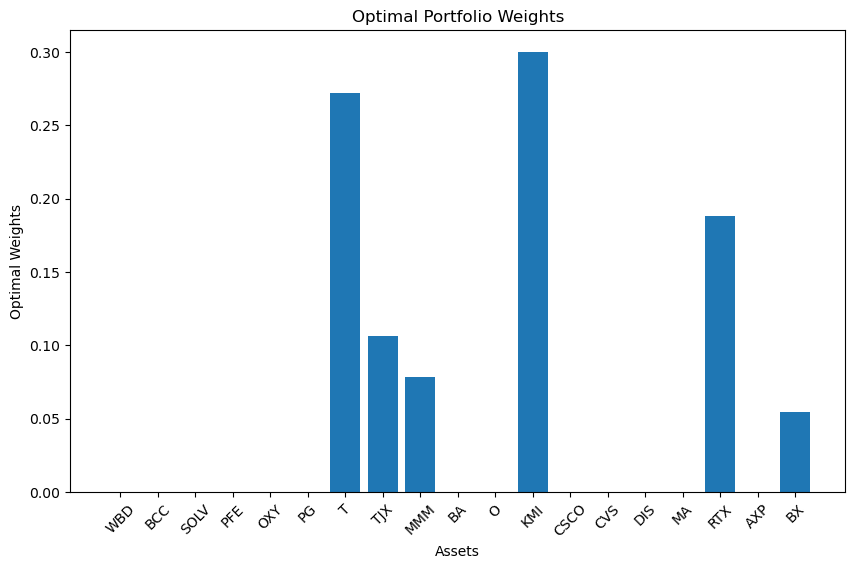

In [85]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')
# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)
plt.show()